### Light Autoencoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torch.utils.data import DataLoader
from torchmetrics import PeakSignalNoiseRatio
from torchmetrics import StructuralSimilarityIndexMeasure

from tqdm import tqdm

import random
import numpy as np

from utils.dataset import HazeDataset
from utils.trainer import Trainer
from utils.utils import plot_predict_pytorch
from utils.utils import save_images_pytorch
from utils.utils import plot_historial_pytorch


#### Dataset

In [2]:
# Train, Validation and Test Dataset

train_image_path = "/home/maldonadoq/Datasets/Reside/Standard/SOTS/indoor/gt/"
train_haze_path = "/home/maldonadoq/Datasets/Reside/Standard/SOTS/indoor/hazy/"
val_image_path = "/home/maldonadoq/Datasets/Reside/Standard/SOTS/indoor/gt_val/"
val_haze_path = "/home/maldonadoq/Datasets/Reside/Standard/SOTS/indoor/hazy_val/"
test_image_path = "/home/maldonadoq/Datasets/Reside/Standard/OWN/gt/"
test_haze_path = "/home/maldonadoq/Datasets/Reside/Standard/OWN/hazy/"
checkpoint_path = "/home/maldonadoq/University/Unicamp/Master/Paper/LA-CCI/model/autoencoder-sots.pth.tar"

# train_image_path = "/home/maldonadoq/Datasets/Reside/Standard/ITS/clear/"
# train_haze_path = "/home/maldonadoq/Datasets/Reside/Standard/ITS/hazy/"
# val_image_path = "/home/maldonadoq/Datasets/Reside/Standard/SOTS/indoor/gt/"
# val_haze_path = "/home/maldonadoq/Datasets/Reside/Standard/SOTS/indoor/hazy/"
# test_image_path = "/home/maldonadoq/Datasets/Reside/Standard/OWN/gt/"
# test_haze_path = "/home/maldonadoq/Datasets/Reside/Standard/OWN/hazy/"
# checkpoint_path = "/home/maldonadoq/University/Unicamp/Master/Paper/LA-CCI/model/autoencoder-its.pth.tar"

In [3]:
learning_rate = 1e-4
batch_size_train = 32
batch_size_val_test = 8
num_workers = 2
pin_memory = True
size = 256

transf_torch_to_img = transforms.ToPILImage()
transf_img_to_torch = transforms.Compose([
    transforms.Resize([size, size]),
    transforms.ToTensor()
])

train_dataset = HazeDataset(train_haze_path, train_image_path, transf_img_to_torch)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size_train,
    num_workers=num_workers,
    pin_memory=pin_memory,
    shuffle=True
)

val_dataset = HazeDataset(val_haze_path, val_image_path, transf_img_to_torch)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size_val_test,
    num_workers=num_workers,
    pin_memory=pin_memory,
    shuffle=False
)

test_dataset = HazeDataset(test_haze_path, test_image_path, transf_img_to_torch)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size_val_test,
    num_workers=num_workers,
    pin_memory=pin_memory,
    shuffle=False
)

#### Model

In [4]:
class LightNet(nn.Module):
    def __init__(self, channels=1):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 50, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.AvgPool2d(2),

            nn.Conv2d(50, 50, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.AvgPool2d(2),

            # nn.Linear(64, 10),
            # nn.ReLU()
        )

        self.decoder = nn.Sequential(
            # nn.Linear(10, 64),
            # nn.ReLU(),

            nn.Conv2d(50, 50, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(50, 50, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(50, channels, kernel_size=3, padding='same'),
            nn.ReLU()
        )
        
        self.b = 1

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        output = decoded * x - decoded + self.b

        return output


In [5]:
# a = torch.zeros([1, 3, 256, 256])

# light = LightNet(channels=3)
# b = light(a)
# print(b.shape)

#### Training

In [6]:
class DehazingTrainer(Trainer):
    def train(self, loader):
        loop = tqdm(loader)

        losses = []
        for haze, image in loop:
            haze = haze.to(device=self.device)
            image = image.to(device=self.device)

            # forward
            with torch.cuda.amp.autocast():
                pred = self.model(haze)
                loss = self.loss(pred, image)

            # backward
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # update tqdm
            loop.set_postfix(loss=loss.item())
            losses.append(loss.item())

        return np.sum(losses)/len(losses)

In [7]:
model = LightNet(channels=3)
loss = nn.MSELoss()
metrics = dict({
    'ssim': StructuralSimilarityIndexMeasure(),
    'psnr': PeakSignalNoiseRatio()
})
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate
)

dehazing = DehazingTrainer(model, loss, optimizer, metrics, checkpoint_path, initial=True)
historial = dehazing.fit(train_loader, val_loader, 25)
historial


Epoch 1/25


100%|██████████| 16/16 [00:05<00:00,  2.74it/s, loss=0.443]


Epoch 2/25


100%|██████████| 16/16 [00:05<00:00,  2.68it/s, loss=0.367]


Epoch 3/25


100%|██████████| 16/16 [00:05<00:00,  2.80it/s, loss=0.206]


Epoch 4/25


100%|██████████| 16/16 [00:08<00:00,  1.85it/s, loss=0.173]


Epoch 5/25


100%|██████████| 16/16 [00:06<00:00,  2.64it/s, loss=0.138]


Epoch 6/25


100%|██████████| 16/16 [00:06<00:00,  2.61it/s, loss=0.157]


Epoch 7/25


100%|██████████| 16/16 [00:05<00:00,  3.13it/s, loss=0.155]


Epoch 8/25


100%|██████████| 16/16 [00:06<00:00,  2.64it/s, loss=0.153]


Epoch 9/25


100%|██████████| 16/16 [00:05<00:00,  3.11it/s, loss=0.143]


Epoch 10/25


100%|██████████| 16/16 [00:05<00:00,  2.85it/s, loss=0.141]


Epoch 11/25


100%|██████████| 16/16 [00:05<00:00,  3.12it/s, loss=0.143]


Epoch 12/25


100%|██████████| 16/16 [00:04<00:00,  3.23it/s, loss=0.149]


Epoch 13/25


100%|██████████| 16/16 [00:04<00:00,  3.39it/s, loss=0.107]


Epoch 14/25


100%|██████████| 16/16 [00:05<00:00,  3.02it/s, loss=0.0343]


Epoch 15/25


100%|██████████| 16/16 [00:05<00:00,  3.06it/s, loss=0.0259]


Epoch 16/25


100%|██████████| 16/16 [00:04<00:00,  3.20it/s, loss=0.0218]


Epoch 17/25


100%|██████████| 16/16 [00:05<00:00,  3.15it/s, loss=0.0176]


Epoch 18/25


100%|██████████| 16/16 [00:04<00:00,  3.29it/s, loss=0.018] 


Epoch 19/25


100%|██████████| 16/16 [00:05<00:00,  3.11it/s, loss=0.0179]


Epoch 20/25


100%|██████████| 16/16 [00:04<00:00,  3.33it/s, loss=0.0187]


Epoch 21/25


100%|██████████| 16/16 [00:05<00:00,  2.86it/s, loss=0.0178]


Epoch 22/25


100%|██████████| 16/16 [00:05<00:00,  3.12it/s, loss=0.0192]


Epoch 23/25


100%|██████████| 16/16 [00:05<00:00,  3.10it/s, loss=0.0138]


Epoch 24/25


100%|██████████| 16/16 [00:05<00:00,  2.97it/s, loss=0.016] 


Epoch 25/25


100%|██████████| 16/16 [00:05<00:00,  2.93it/s, loss=0.0229]


[(0.4491893704980612, {'ssim': 0.26114926, 'psnr': 3.6795583}),
 (0.4145399145781994, {'ssim': 0.31765184, 'psnr': 4.303051}),
 (0.3030684841796756, {'ssim': 0.53013766, 'psnr': 7.1802635}),
 (0.16081222612410784, {'ssim': 0.41240478, 'psnr': 7.9657197}),
 (0.1519770622253418, {'ssim': 0.64991105, 'psnr': 8.567259}),
 (0.14510901272296906, {'ssim': 0.6418948, 'psnr': 8.56593}),
 (0.14603803306818008, {'ssim': 0.6383244, 'psnr': 8.566637}),
 (0.1447006305679679, {'ssim': 0.6469411, 'psnr': 8.593697}),
 (0.14417152013629675, {'ssim': 0.64530444, 'psnr': 8.598085}),
 (0.14329126942902803, {'ssim': 0.64870036, 'psnr': 8.612286}),
 (0.14285956881940365, {'ssim': 0.6513753, 'psnr': 8.62406}),
 (0.1423798743635416, {'ssim': 0.65315425, 'psnr': 8.634121}),
 (0.13691433612257242, {'ssim': 0.6892122, 'psnr': 10.747614}),
 (0.04131144261918962, {'ssim': 0.7309657, 'psnr': 15.440197}),
 (0.028482462977990508, {'ssim': 0.8276057, 'psnr': 17.429499}),
 (0.02228579402435571, {'ssim': 0.8227347, 'psnr

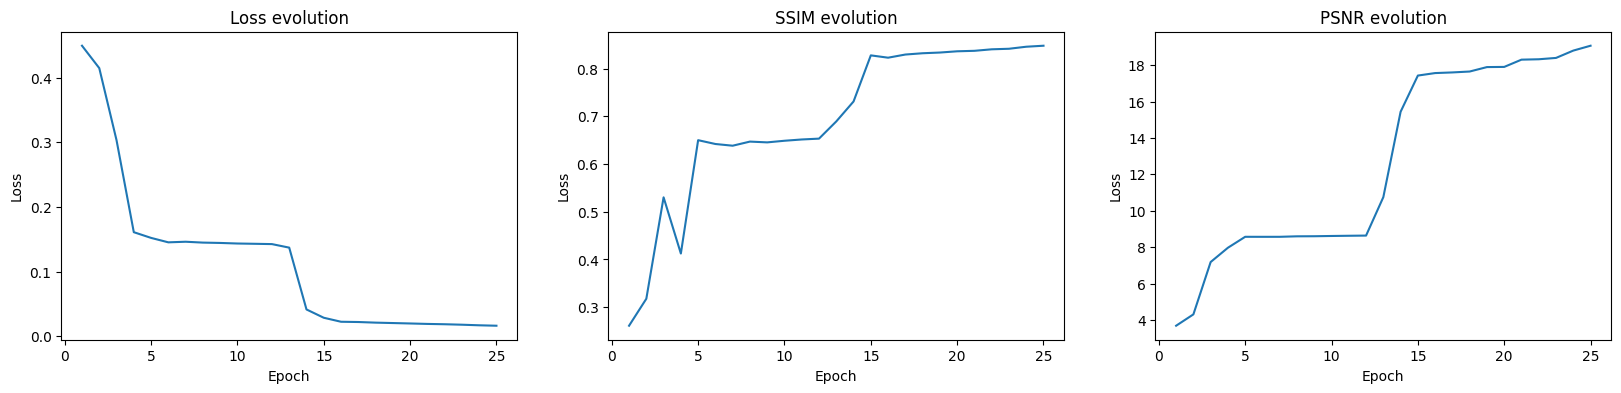

In [8]:
plot_historial_pytorch(historial)

#### Testing

In [9]:
accuracy = dehazing.accuracy(test_loader)
results = dehazing.predict(test_loader)
accuracy

{'ssim': 0.8256932, 'psnr': 15.139677}

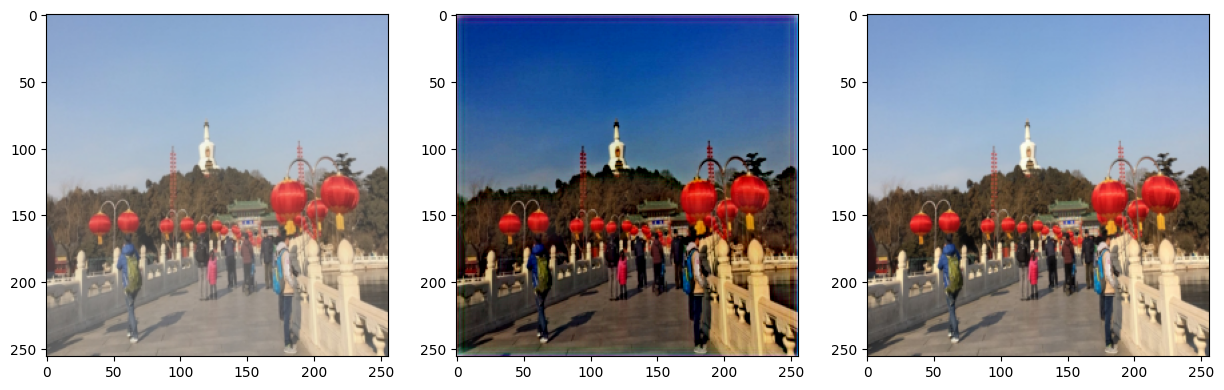

In [10]:
plot_predict_pytorch(results, transf_torch_to_img)
save_images_pytorch(results, transf_torch_to_img, size, 'light', './images/')